## Lecture 11 - Models with memory

McElreath's lectures for today: https://www.youtube.com/watch?v=SocRgsf202M&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp 
import random as rd
import pdb
import pymc as pm
import arviz as az
import networkx as nx
from matplotlib import pyplot as plt
import dataframe_image as dfi


# Helper functions
def stdize(x):
    return (x-np.mean(x))/np.std(x)


def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def indexall_(L):
    Il, Ll = pd.factorize(L, sort=True)
    return Ll, Il

def invlogit(p):
    return np.exp(p) / (1 + np.exp(p))

# Hierarchical (multi-level) models

And now we have arrived at the good stuff - the most applicable aspect of Bayesian statistics. Hierarchical models. They are spectacularly useful because the world itself is hierarhical in space and time. Being able to recognize this, and build models that leverage it to improve predictive performance, lies at the heart of what we're about. So what do hierarhical models do? They share information among related groups or, put differently, they don't forget what each part a model does when they're estimating the other parts. **They should be your default approach**. Why? Because they regularize by default, helping to generalized for out of sample prediction, which is typically what we want to do. 

Let's begin with an example of tadpole predation where we have an experimental treatment relating to the numbers of tadpoles surviving in experimental tanks of varying sizes, with various densities of other tadpoles and predators. This kind of experiment is to tease apart the effects of density-dependence (self limitation of a population due to limitation of resources) and predation. 

In [2]:
tdata = pd.read_csv('reedfrogs.csv')
dfi.export(tdata.head(), 'tdata.jpg')
tdata.head()

[43498:63235:1104/202325.627745:ERROR:trust_store_mac.cc(817)] Error parsing certificate:
ERROR: Failed parsing extensions

[43505:23299:1104/202326.685039:ERROR:shared_image_manager.cc(509)] SharedImageManager::ProduceMemory: Trying to Produce a Memory representation from a non-existent mailbox.
46183 bytes written to file /var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/tmpno5562if/temp.png


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


To set up our introduction to hierarhical models, we'll develop three models looking at variation in survival among tanks: 

1. Treats every tank as independent (the **no pooling** model of *fixed effects* for each tank)
2. Treat every tank as all the same (the **complete pooling** model for a single, overall effect)
3. Treat every tank as a sample (the **partial pooling** *multi-level* (*hierarchical*) model of *random effects*)

I'm going to stick to using the word hierarchical because it describes (to me at least) what's going on in these models in terms of the dependencies within the data. 'Multi-level' is often used too, but it's less clear and 'random effects' are also used but this gets us further still from a word people actually use and obfuscates the nestedneess of the data. 

In Bayesian notation, our three models are:


$$
\begin{align}
S_i \sim & Bin(D_i,p_i) \\
logit(p_i) = & \beta_{t} \\
\beta_{t} = & N(0, 1.5)
\end{align}
$$

with independent priors for each tank ($t$) in the no pooling model. For the complete pooling model

$$
\begin{align}
S_i \sim & Bin(D_i,p_i) \\
logit(p_i) = & \beta_{0} \\
\beta_{0} = & N(0, 1.5)
\end{align}
$$

and the partial pooling pooling model we have

$$
\begin{align}
S_i \sim & Bin(D_i,p_i) \\
logit(p_i) = & \beta_{t} \\
\beta_{t} \sim & N(\mu, \sigma) \\
\mu \sim & N(0, 1.5) \\
\sigma \sim & E(1).
\end{align}
$$

We can then translate these into three Bayesian models in PyMC

In [3]:
# Grab tank numbers
It = tdata.index.values
ntank = len(It)

# Grab tank densities
D = tdata.density.values

# Grab tank survival
S = tdata.surv.values

# Raw proportions surviving in each tank
psurv = S/D

# Predator indicator
Ip = (tdata.pred.values=='pred')*1

In [4]:
# No pooling model
with pm.Model() as no_pool:
    # Individual tank intercepts
    βt = pm.Normal('Tank', 0, 1.5, shape=ntank)
    
    # Linear model
    p = pm.invlogit(βt)
    
    # Data likelihood
    Yi = pm.Binomial('Yi',D, p, observed=S)

In [5]:
# Complete pooling model
with pm.Model() as pooled:
    # Overall mean
    β0 = pm.Normal('Overall_mean', 0, 1.5)
    
    # Linear model
    p = pm.invlogit(β0)
    
    # Data likelihood
    Yi = pm.Binomial('Yi',D, p, observed=S)

In [6]:
# Partial pooling model
with pm.Model() as par_pool:
    # Overall mean
    μ = pm.Normal('Overall_mean', 0, 1.5)
    # Among-tank variation
    σ = pm.Exponential('Sigma', 1)
    
    # Tank-level intercepts
    βt = pm.Normal('Tank', μ, σ, shape=ntank)
    
    # Linear model
    p = pm.invlogit(βt)
    
    # Data likelihood
    Yi = pm.Binomial('Yi',D, p, observed=S)

With these models in place, we can hit the magic inference button:

In [7]:
with no_pool:
    trace_np = pm.sample(1000)
with pooled:
    trace_p = pm.sample(1000)
with par_pool:
    trace_pp = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Overall_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Overall_mean, Sigma, Tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


First, let's take a look at what WAIC says about the relative weights of evidence for these models

In [8]:
with no_pool:
    pm.compute_log_likelihood(trace_np)
with pooled:
    pm.compute_log_likelihood(trace_p)
with par_pool:
    pm.compute_log_likelihood(trace_pp)

In [9]:
compare_dict = {"no pooling": trace_np, "partial pooling": trace_pp, "pooled":trace_p}
tmp = az.compare(compare_dict)
dfi.export(tmp, 'polewaic.jpg')
tmp

/Users/aaronmacneil/miniforge3/envs/gsm-project/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/aaronmacneil/miniforge3/envs/gsm-project/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/aaronma

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
partial pooling,0,-111.266363,32.227325,0.000000,1.000000e+00,4.176639,0.000000,True,log
no pooling,1,-120.604713,38.888801,9.338350,0.000000e+00,2.557684,2.648915,True,log
pooled,2,-292.317760,10.828029,181.051397,2.958300e-12,34.400593,32.347481,False,log


This is a huge win for the partial pooling model - why? Well let's dig in and take a look at the data: 

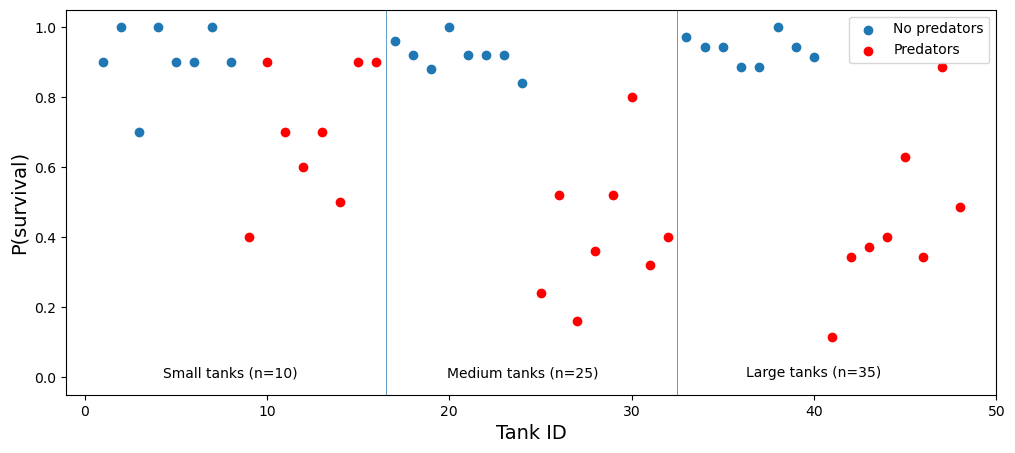

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(np.arange(1, 49)[Ip==0], psurv[Ip==0], label='No predators')
ax.scatter(np.arange(1, 49)[Ip==1], psurv[Ip==1], c='red', label='Predators')
ax.vlines([16.5, 32.5], -.05, 1.05, lw=.5)
ax.text(8, 0, "Small tanks (n=10)", horizontalalignment='center')
ax.text(16+8, 0, "Medium tanks (n=25)", horizontalalignment='center')
ax.text(32+8, 0, "Large tanks (n=35)", horizontalalignment='center')
ax.set_xlabel('Tank ID', fontsize=14)
ax.set_ylabel('P(survival)', fontsize=14)
ax.set_xlim(-1, 50)
ax.set_ylim(-.05, 1.05)
ax.legend()
plt.savefig('tanks.jpg',dpi=300);

From this plot of the raw data, it is clear that - where predators are present (red dots) - the proportion of tadpoles surviving in each tank declines as the initial density of tadpoles increases from small to large. We can also see that  that density doesn't appear to have much of an effect where predators are absent as all the blue dots (bar one low one amongst the small density tanks) are about the same. 

So why is the partial pooling model favoured here? Well this plot makes it clear there are differences in survival among tanks, making the complete pooling model less likely (it assumes they all have about the same mean, or at least a normal distribution of variantion on the log-odds scale

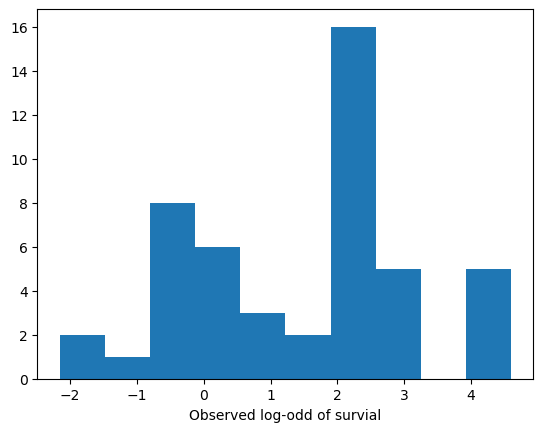

In [11]:
plt.hist(sp.special.logit(psurv-0.01))
plt.xlabel('Observed log-odd of survial')
plt.savefig('los.jpg',dpi=300);

which is clearly not the case). The no pooling model assumes that all of the tanks are just independent, with no relatinoship among them, in which case we'd expect to see no predator/non-predator clustering and a random assortment of survival amongst tank densities. This clearly isn't the case either. Even though we haven't included either the predator effects in our model, the partial-pooling model does better than the other extreemes because it recognizes there is some intrinisc structre in terms of expected survival - in this case that the tank densities (and therefore the amount of information present) vary among tanks. To see this more clearly we can plot the expected values under the partial pooling model against their observed proportions 

In [12]:
# Grab partial pooled expected values on the probability scale
post = trace_pp.posterior['Tank'].to_dataframe().groupby(level=['Tank_dim_0']).apply(np.median)
Esurv = invlogit(post.values)

# Grab no pooling expected values on the probability scale
postnp = trace_np.posterior['Tank'].to_dataframe().groupby(level=['Tank_dim_0']).apply(np.median)
Esurvnp = invlogit(postnp.values)

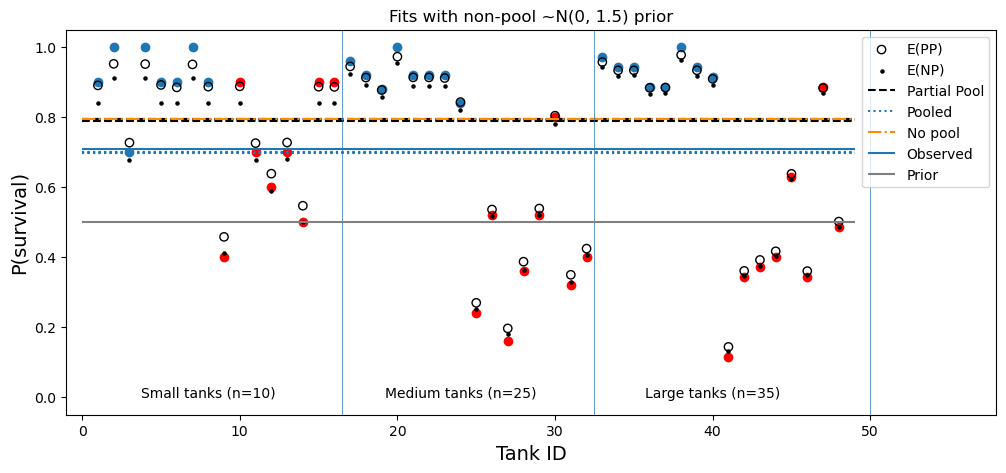

In [28]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(np.arange(1, 49)[Ip==0], psurv[Ip==0])
ax.scatter(np.arange(1, 49)[Ip==1], psurv[Ip==1], c='red')
ax.scatter(np.arange(1, 49), Esurv, facecolors='none', edgecolors='k', lw=1, label='E(PP)')
ax.scatter(np.arange(1, 49), Esurvnp, c='black', s=5, label='E(NP)')
ax.hlines(invlogit(np.median(trace_pp.posterior['Overall_mean'], axis=1)), 0, 49, linestyles='--', label='Partial Pool', color='black')
ax.hlines(invlogit(np.median(trace_p.posterior['Overall_mean'], axis=1)), 0, 49, linestyles=':', label='Pooled')
ax.hlines(invlogit(np.median(trace_np.posterior['Tank'])), 0, 49, color='darkorange', linestyles='-.', label='No pool')
ax.hlines(invlogit(np.median(psurv)), 0, 49, label='Observed')
ax.hlines(.5, 0, 49, label='Prior', color='grey',zorder=0)
ax.vlines([16.5, 32.5, 50], -.05, 1.05, lw=.5)
ax.text(8, 0, "Small tanks (n=10)", horizontalalignment='center')
ax.text(16+8, 0, "Medium tanks (n=25)", horizontalalignment='center')
ax.text(32+8, 0, "Large tanks (n=35)", horizontalalignment='center')
ax.set_xlabel('Tank ID', fontsize=14)
ax.set_ylabel('P(survival)', fontsize=14)
ax.set_xlim(-1, 58)
ax.set_ylim(-.05, 1.05)
plt.legend()
plt.title('Fits with non-pool ~N(0, 1.5) prior')
plt.savefig('modelfits.jpg',dpi=300);

How to think about these results:

*Complete pooling is maximum* **underfitting** - ignoring all the actual heterogenity in the population; model is too simple (*i.e.* set σ to 0)

*No pooling is (close to) maximum* **overfitting** - focused entirely on the heterogenity and using a tiny amount of data to fit each parameter; model is too ignorant and learns nothing from the population of tanks (*i.e.* σ goes to $\infty$)

*Partial pooling is* **adaptive regularization** - we learn the level of regularization from the data itself:

In [14]:
# Sigma posterior
sigma_posterior = trace_pp.posterior['Sigma'][0]
# Sigma prior
sigma_prior = np.random.exponential(1,len(sigma_posterior))

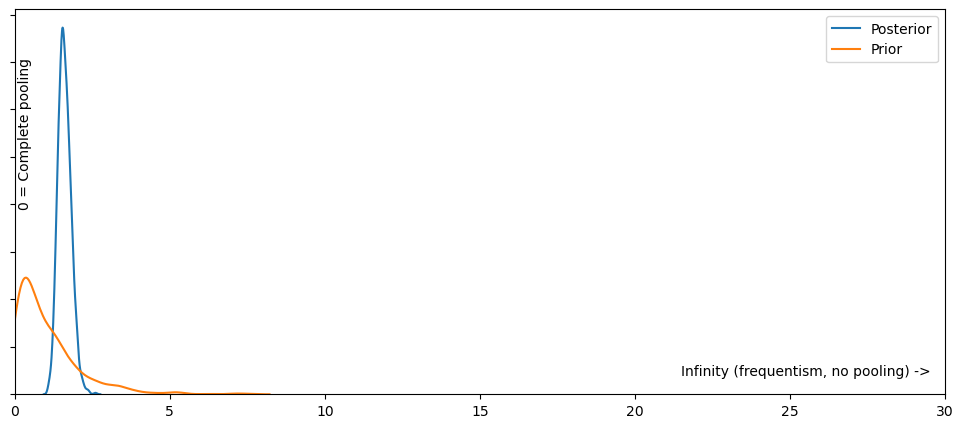

In [15]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.kdeplot(sigma_posterior,label='Posterior')
sns.kdeplot(sigma_prior,label='Prior')
ax.tick_params(labelleft=False)
plt.text(21.5,0.1,'Infinity (frequentism, no pooling) ->')
plt.text(0.1,0.99,'0 = Complete pooling', rotation=90)
plt.legend()
plt.xlim(0,30)
plt.ylabel('')
plt.savefig('priorpost.jpg',dpi=300);

On the left hand side is zero - the complete pooling model - and on the right side (eventually) is infinity - the no pooling model. In between we have something that is not these things - the partial pooled model - and the question is, how much partial pooling should there be? Well the maximum entropy answer is the Normal distribution, where the only constraint is finite variance. Beyond that we can let the data decide the appropriate level of regularization, which in this case is estimated at about 1.6 in the blue line above. So why do we want to regularize? Because in doing so we can make better out of sample predictions. Let's try this by simulating a new 'mini tank' with a density of 5 tadpoles along with our other tank densities and see what happens:

In [16]:
# Overall mean
b0_ = 1.4
# Inter-tank variation 
sigma_ = 1.5
# Number of new tanks
ntanks = 60
# Density in each tank
D_ = np.repeat([5, 10, 25, 35], 15)

# Linear model for new data
mu_ = np.random.normal(b0_, sigma_, size=ntanks)

# Link
ptrue = invlogit(mu_)

# New survival data
S_ = np.random.binomial(D_, ptrue)

# Survival proportion
psurv_ = S_/D_

In [17]:
# No pooling model
with pm.Model() as no_pool_sim:
    # Individual tank intercepts
    βt = pm.Normal('Tank', 0, 1.5, shape=ntanks)
    
    # Linear model
    p = pm.invlogit(βt)
    
    # Data likelihood
    Yi = pm.Binomial('Yi',D_, p, observed=S_)

In [18]:
# Partial pooling model
with pm.Model() as par_pool_sim:
    # Overall mean
    μ = pm.Normal('Overall_mean', 0, 1.5)
    # Among-tank variation
    σ = pm.Exponential('Sigma', 1)
    
    # Tank-level intercepts
    βt = pm.Normal('Tank', μ, σ, shape=ntanks)
    
    # Linear model
    p = pm.invlogit(βt)
    
    # Data likelihood
    Yi = pm.Binomial('Yi',D_, p, observed=S_)

In [19]:
with no_pool_sim:
    trace_nps = pm.sample(1000)
with par_pool_sim:
    trace_pps = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Overall_mean, Sigma, Tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Now, we can get the expected values for the individual tank means, and plot them relative to their absolute error

In [20]:
# Expected values
p_no = invlogit(np.median(trace_nps.posterior['Tank'],axis=0)[0])
p_partial = invlogit(np.median(trace_pps.posterior['Tank'],axis=0)[0])

# Absolute error
ae_no = abs(p_no-ptrue)
ae_pp = abs(p_partial-ptrue)


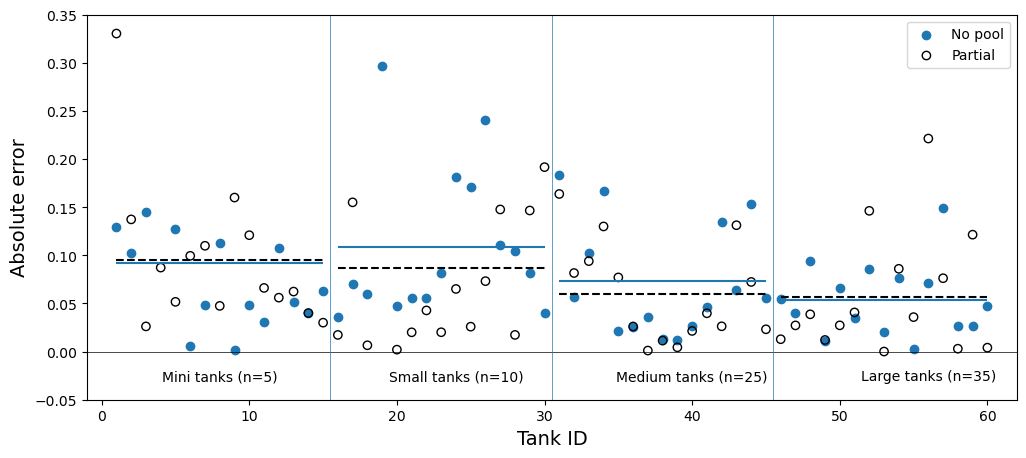

In [21]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
# No pooled absolute errors
ax.scatter(np.arange(ntanks)+1, ae_no, label='No pool')
# Partial pooled absolute errors
ax.scatter(np.arange(ntanks)+1, ae_pp, facecolors='none', edgecolors='k', lw=1, label='Partial')
# Averages per tank density
xrange = np.arange(60)
xrange_ = xrange.reshape((4, 15))
for ix in range(4):
    ax.hlines(ae_no[xrange_[ix, :]].mean(), xrange_[ix, 0]+1, xrange_[ix, -1]+1, color='C0')
    ax.hlines(ae_pp[xrange_[ix, :]].mean(), xrange_[ix, 0]+1, xrange_[ix, -1]+1, color='k', linestyles='--')

# Prettify
ax.axhline(0,c='black', linewidth=0.5)
ax.vlines(xrange_[1:,0]+.5, -.05, 0.35, lw=.5)
ax.text(8, -.03, "Mini tanks (n=5)", horizontalalignment='center')
ax.text(16+8, -.03, "Small tanks (n=10)", horizontalalignment='center')
ax.text(32+8, -.03, "Medium tanks (n=25)", horizontalalignment='center')
ax.text(48+8, -.03, "Large tanks (n=35)", horizontalalignment='center')
ax.set_xlabel('Tank ID', fontsize=14)
ax.set_ylabel('Absolute error', fontsize=14)
ax.set_xlim(-1, 62)
ax.set_ylim(-.05, .35)
plt.legend()
plt.savefig('modelfits3.jpg',dpi=300);

What's crazy here is how much things are improved when there is little data available - in the density=5 tanks, the improvement is huge; among the others the differences decrease as the data become more information rich (due to randomness of the starting values for the simulation your results may differ slightly but re-run to see how on average this is the case).